## Project Start


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, we can use color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Normalize the features and randomize a selection for training and testing.
* Implement a sliding-window technique/Hog sub-sampling window search and use trained classifier to search for vehicles in images.
* Implement heat map to reduce false positive.
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate bounding box for vehicles detected.

In [1]:
## import some libraries ##
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

### get_image_list(path)
This function is used to extract all the image paths from the path passed
    
### data_look(car_list, notcar_list)
This function is used to get the details for the cars list and the notcars list. It returns some characteristics of the dataset. 

In [2]:
def get_image_list(path):
    images_folder = path
    image_array = []
    image_folders = os.listdir(images_folder)
 
    for folder in image_folders :
        image_array.extend(glob.glob(path+folder+'/*'))
    print ("Images : " ,len(image_array))
    return image_array
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # store the number of car images
    data_dict["n_cars"] = len(car_list)
    # store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    example_img = mpimg.imread(car_list[0])
    # store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    return data_dict

### print_random_car_notcar(cars, notcars)
This  function takes cars and notcars list and prints one car image and one not car image

In [3]:
def print_random_car_notcar(cars, notcars):
    # Choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])
    # Plot the car and notcar
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

### get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
This function is used to get the hog features. It returns images and features if vis is passed as true else it will only return the features. These features are then used to tarin the SVM classifier.

In [4]:
from skimage.feature import hog


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                     feature_vec=True):                        

    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        hog_features = return_list
        return hog_features

## More feature extraction functions
 **   1) convert_color(img, conv='RGB2YCrCb') :  **
    Color space conversion function

 **   2) bin_spatial(img, size=(32, 32)) :  **
    resize the image and take the features of the images

 **   3) color_hist(img, nbins=32) :  **
    use color histograms as features for training the SVM

In [5]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

** The features extraction functions defined in the above two blocks are being called here to extract the features. **

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # List to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        #List of all the features on a single image. At the end of each iteration append to features list defined above
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB', as RGB is default color in which images are being read.
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print('Done')

Done


### Random hog car and notcar images
This function prints random hog car and notcar images.

This function is called with main so we can see output there.

In [8]:
def random_hog(car_images):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(car_images))
    # Read in the image
    image = mpimg.imread(car_images[ind])
    #RGB to HLS
    YCrCb_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y_img = YCrCb_image[:,:,0]
    Cr_img = YCrCb_image[:,:,1]
    Cb_img = YCrCb_image[:,:,2]
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S_img = hls_image[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient= 5, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=False)
    
    features1, hog_image1 = get_hog_features(gray, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=False)
    
    features2, hog_image2 = get_hog_features(gray, orient= 14, 
                            pix_per_cell= 8, cell_per_block= 3, 
                            vis=True, feature_vec=False)
    #================= next 4 images =================================#
    features3, hog_image3 = get_hog_features(Y_img, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=False)
    
    features4, hog_image4 = get_hog_features(S_img, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 5, 
                            vis=True, feature_vec=False)
    
    features5, hog_image5 = get_hog_features(Cb_img, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=False)
    
    features6, hog_image6 = get_hog_features(S_img, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 4, 
                            vis=True, feature_vec=False)
    
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 30))
    f.tight_layout()
    ax1.imshow(gray,cmap='gray')
    ax1.set_title('Example Image', fontsize=35)
    ax2.imshow(hog_image,cmap='gray')
    ax2.set_title('HOG Visualization 1', fontsize=35)
    ax3.imshow(hog_image1,cmap='gray')
    ax3.set_title('HOG Visualization 2', fontsize=35)
    ax4.imshow(hog_image2,cmap='gray')
    ax4.set_title('HOG Visualization 3', fontsize=35)
    
    f, (ax5, ax6, ax7, ax8) = plt.subplots(1, 4, figsize=(30, 30))
    f.tight_layout()
    ax5.imshow(hog_image3,cmap='gray')
    ax5.set_title('HOG Visualization 4', fontsize=35)
    ax6.imshow(hog_image4,cmap='gray')
    ax6.set_title('HOG Visualization 5', fontsize=35)
    ax7.imshow(hog_image5,cmap='gray')
    ax7.set_title('HOG Visualization 6', fontsize=35)
    ax8.imshow(hog_image6,cmap='gray')
    ax8.set_title('HOG Visualization 7', fontsize=35)
    
    
#     f, (ax9, ax10, ax11, ax12) = plt.subplots(1, 4, figsize=(30, 30))
#     f.tight_layout()
#     ax9.imshow(Y_img,cmap='gray')
#     ax9.set_title('HOG Visualization 5', fontsize=35)
#     ax10.imshow(Cr_img,cmap='gray')
#     ax10.set_title('HOG Visualization 6', fontsize=35)
#     ax11.imshow(Cb_img,cmap='gray')
#     ax11.set_title('HOG Visualization 7', fontsize=35)
#     ax12.imshow(S_img,cmap='gray')
#     ax12.set_title('HOG Visualization 8', fontsize=35)
    
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combine the feature set of car and notcars so that we can split it into training and test data after shuffling.

In [9]:
def combine_dataset(features_car, features_notcar):
    dataset = np.vstack((features_car, features_notcar)).astype(np.float64)
    dataset_labels = np.hstack(( np.ones(len(features_car)), np.zeros(len(features_notcar))))
    print( len(dataset))
    return dataset, dataset_labels


### get_X_train_Y_train(cars, notcars)

This function takes in image path for cars and notcars. Then it extracts the features of both these datasets. Once we have the features they are combined using combine_dataset(features_car, features_notcar) function. After that it is split into training and test data set in 8:2 ratio.

I am using YCrCb color space to extract the features. I have tested with RGB as well but for me YCrCb is giving better results. I have used 16 pixels per cell, as it helps to reduce the parameters and train the model faster and does not affect the accuracy in any way. I have used cells_per_block as 3 because I tried with various parameters and it suits my model best.

I am using hog features along with spacial bin and histogram features as I found that hog features were not enough for accurate classification.

In [10]:
import os.path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC




def get_X_train_Y_train(cars, notcars):
    print("Total car images : ", len(cars))
    print("Total notcar images : ", len(notcars))
    print('Pickle not found, getting training and testing data sets')
    
    colorspace = 'YCrCb'
    orient = 9
    pix_per_cell = 16
    cell_per_block = 3
    hog_channel = 'ALL'
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    features_car = extract_features(cars, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    features_notcar = extract_features(notcars, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
     

    print("Hog car image features :", len(features_car))
    print("Hog notcar image features :", len(features_notcar))
    print("Hog car images shape : ", features_car[0].shape)
    print("Hog notcar images shape : " ,features_notcar[0].shape)

    dataset, dataset_labels = combine_dataset(features_car, features_notcar)

    print("Data set length : ", len(dataset), "    Dataset labels length : ", len(dataset_labels))
    X_train , X_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size = 0.2)

    return X_train, X_test, y_train, y_test

## Classifier training
I am using SVM to classify my images. I have tried using Linear and rbf kernel. I am getting better results with rbf kernel with an accuracy of about ~99.5%. I think it is pretty decent accuracy. Also I have tried various combinations of the C with the kernel and C=10 suits best.

In [11]:
def train_svm(X_train , X_test, y_train, y_test):
    
    clf = SVC(kernel = 'rbf', C=10)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    
    print(acc)
        
    return clf, acc

## find_cars(img, ystarts, ystops, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors)

After training the data and testing SVM classifier, we need to use it. It is here that we use it. It extract the features from the frame of the video and then it sends to the classifier for classification. I am not sending the full image for classification but small windows from the image. 

I am using Hog-Sub sampling method as it is less compute intensive.

In [12]:
def find_cars(img, ystarts, ystops, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    for scale, ystart, ystop, color in zip(scales, ystarts, ystops, colors) :
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
                
                #test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))   
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                #if test_prediction == 1 or test_prediction == 0:
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),color,6)
#     plt.figure()
#     plt.imshow(draw_img)

    return bboxes, draw_img

## Main function
This function checks if we already have the pickle and if the pickle has values. If that is the case then we don't need to extract the features and train the model to get the classifier. We just need to read the pickle and get the values.

What this function does in a bit more detail :

    1) Gets the list of cars and notcars
    2) Prints random car and not car
    3) Prints random Hog image
    4) If pickle is not there , then extract features, gets the training and test data else gets the SVM and X_Scaler
    5) Trains the classifier
    5) Saves trhe values to pickle


In [13]:
import pickle

def main_function():

    #cars = get_image_list('training_data/vehicles_smallset/')
    #notcars = get_image_list('training_data/non-vehicles_smallset/')
    cars = get_image_list('training_data/vehicles/')
    notcars = get_image_list('training_data/non-vehicles/')
    
    print('All images loaded')
    
    data_info = data_look(cars, notcars)

    print('Your function returned a count of', 
          data_info["n_cars"], ' cars and', 
          data_info["n_notcars"], ' non-cars')
    print('of size: ',data_info["image_shape"], ' and data type:', 
          data_info["data_type"])

    print_random_car_notcar(cars, notcars)
    random_hog(cars)
    random_hog(notcars)

    check_if_exits = os.path.isfile("pickle_data_rbf_4x4.p") 

    if check_if_exits == True :
        read_pickle_data = pickle.load( open( "pickle_data_rbf_4x4.p", "rb" ) )
        X_scaler = read_pickle_data["X_scaler"]
        svc = read_pickle_data["svc"]
        acc = read_pickle_data["acc"]
        print('Data read from pickle')
        print(X_scaler)
        print("Accuracy : ", acc)
    else :
        print('Error reading pickle')

        X_train, X_test, y_train, y_test = get_X_train_Y_train(cars, notcars)
        
        print ("cars_X_train : ", len(X_train))
        print ("cars_X_test : ", len(X_test))

        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)
        
        
        print(len(X_train[0]))
        
        svc, acc = train_svm(X_train , X_test, y_train, y_test)

        write_pickle_data = {}
        write_pickle_data["X_scaler"] = X_scaler
        write_pickle_data["svc"] = svc     
        write_pickle_data['acc'] = acc
        pickle.dump( write_pickle_data, open( "pickle_data_rbf_4x4.p", "wb" ) )
    return svc, X_scaler



** Getting the svc and X_scaler by calling main_function  **

Images :  8792
Images :  8968
All images loaded
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


D:\carND\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Data read from pickle
StandardScaler(copy=True, with_mean=True, with_std=True)
Accuracy :  0.997184684685


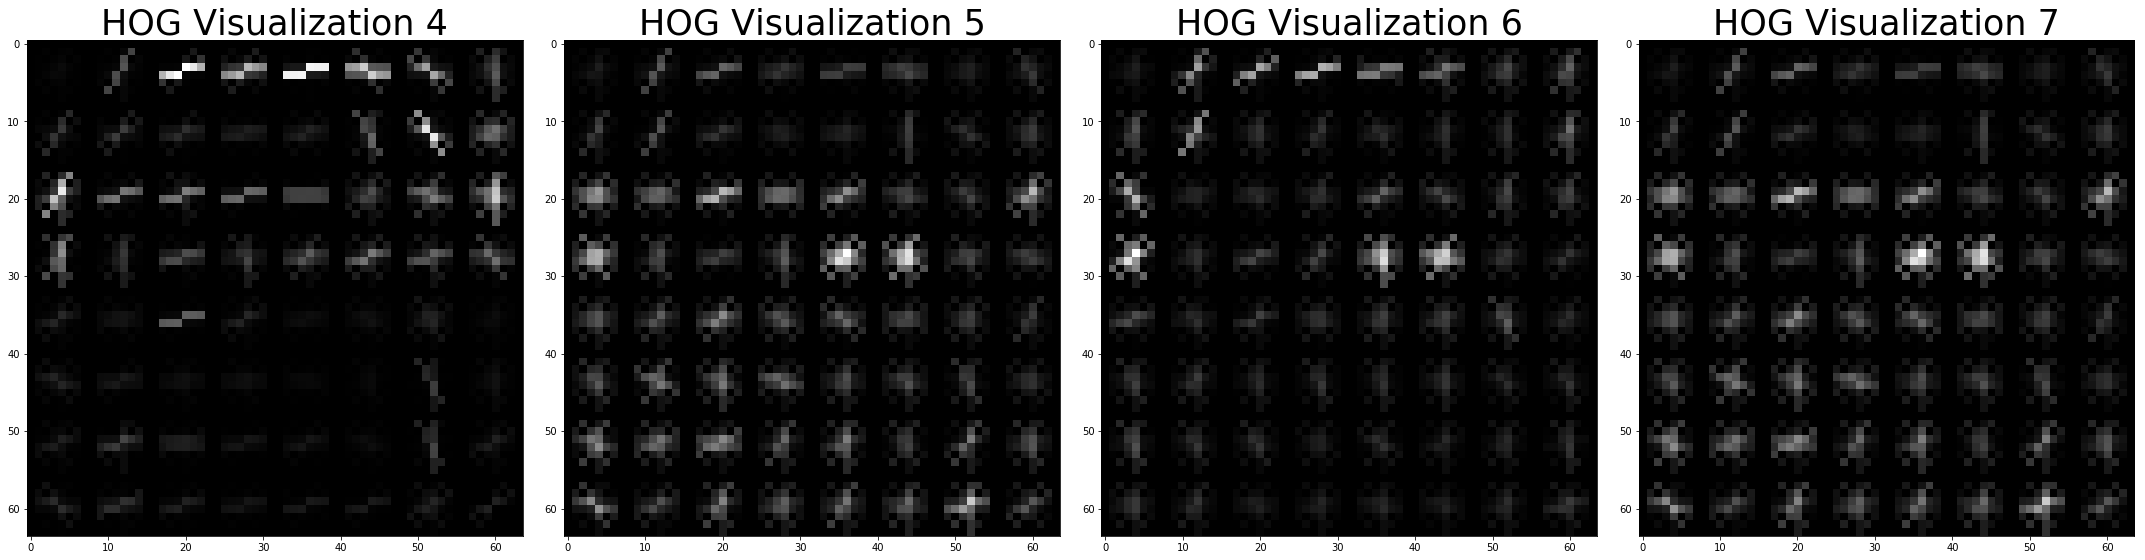

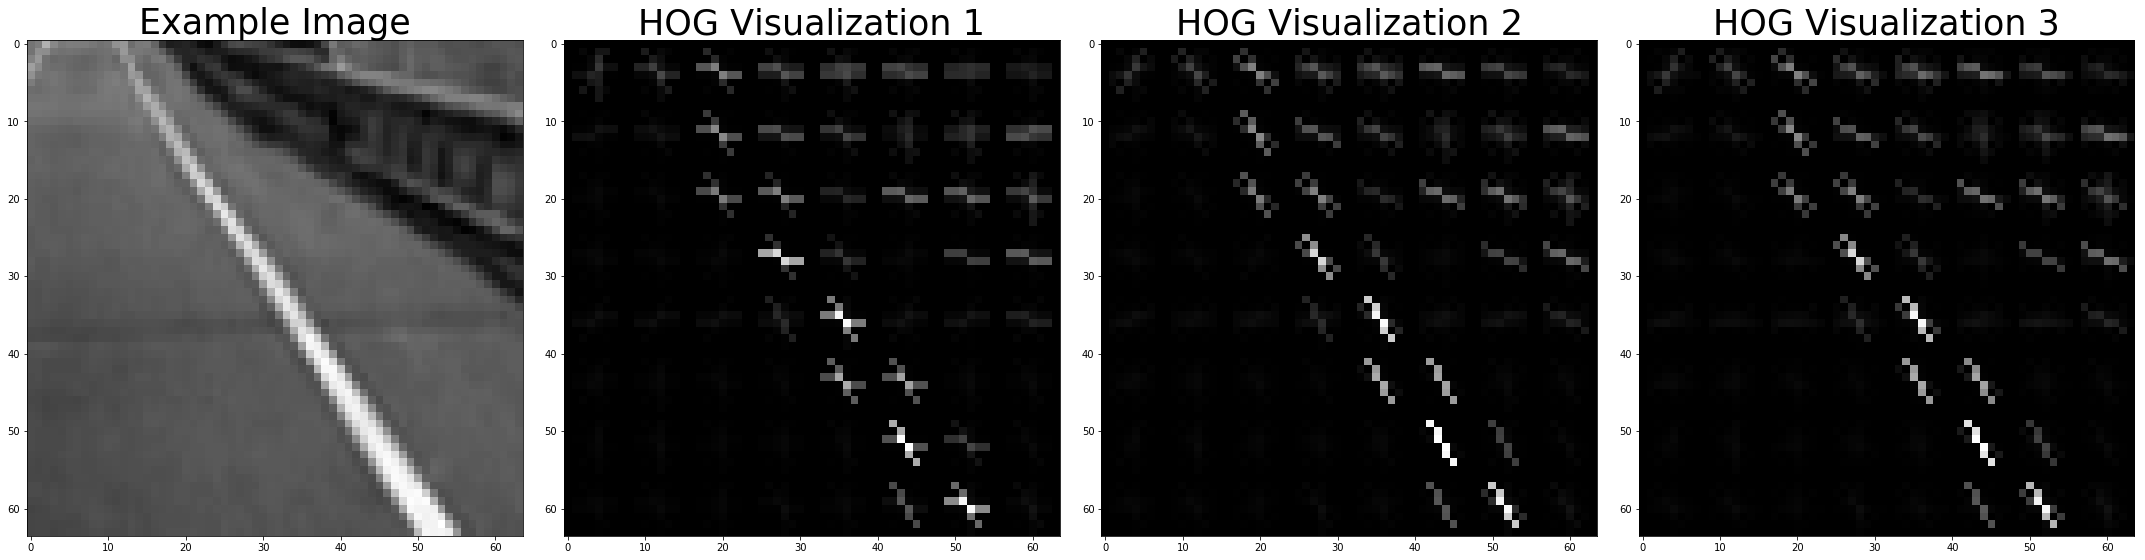

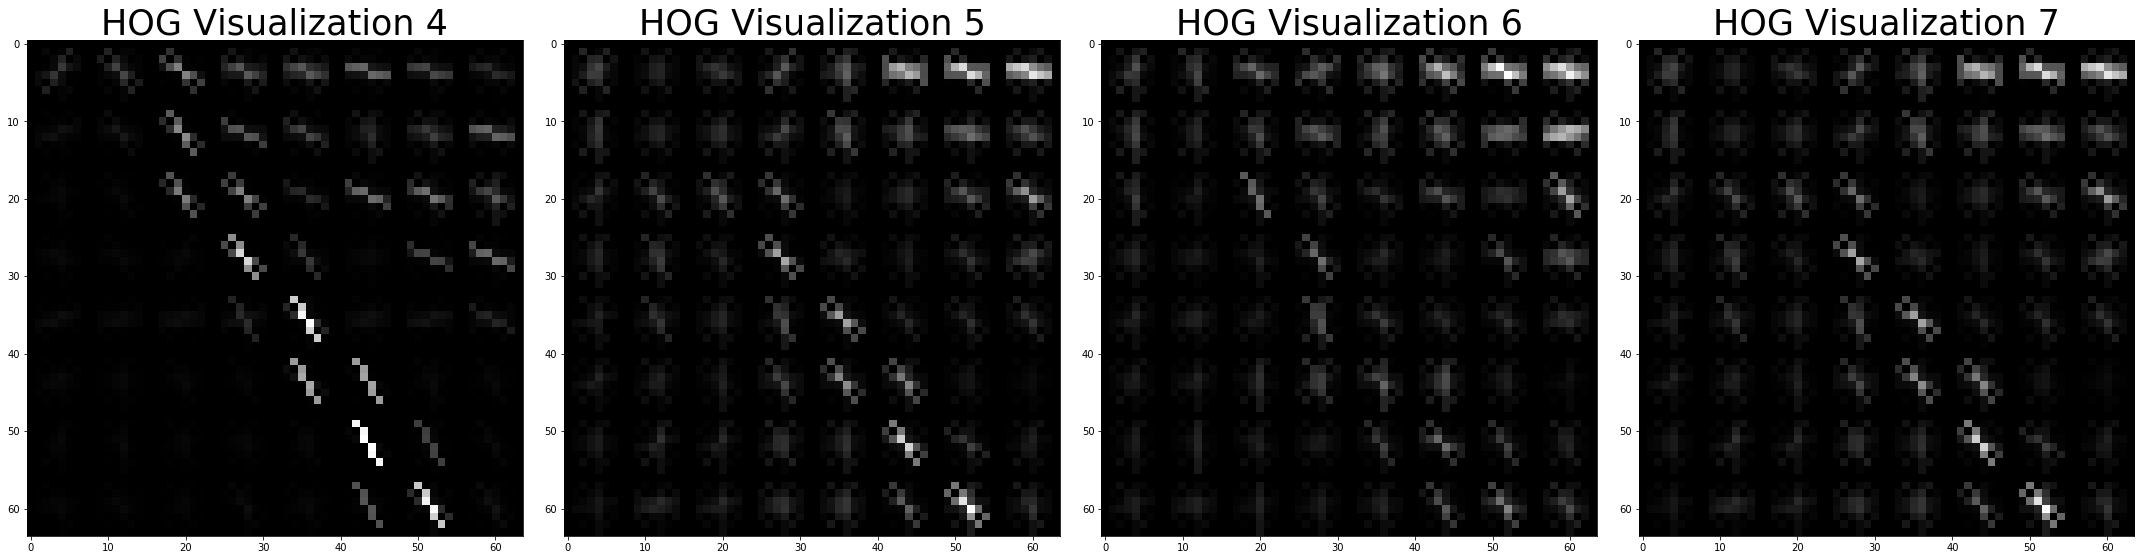

In [14]:
svc, X_scaler = main_function()

### Helper functions for heatmaps. 

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def remove_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Process the image

We have SVC and X_scaler. It calls find_cars method to detect the cars. Then it uses the heatmaps to remove noise. My heat threshold is zero as I have no false positives detected.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Images :  8792
Images :  8968
All images loaded
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


D:\carND\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Data read from pickle
StandardScaler(copy=True, with_mean=True, with_std=True)
Accuracy :  0.997184684685


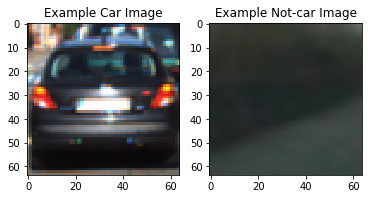

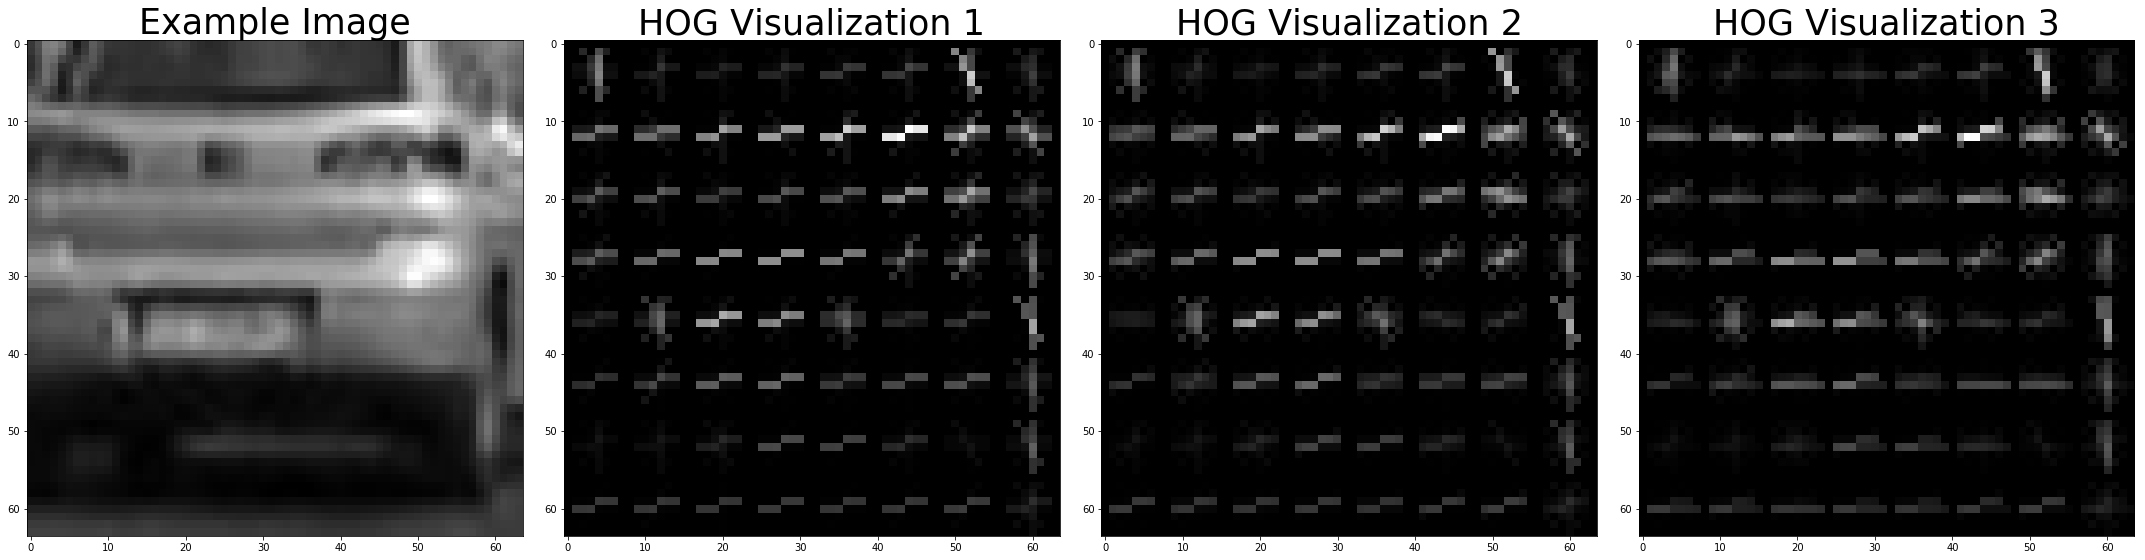

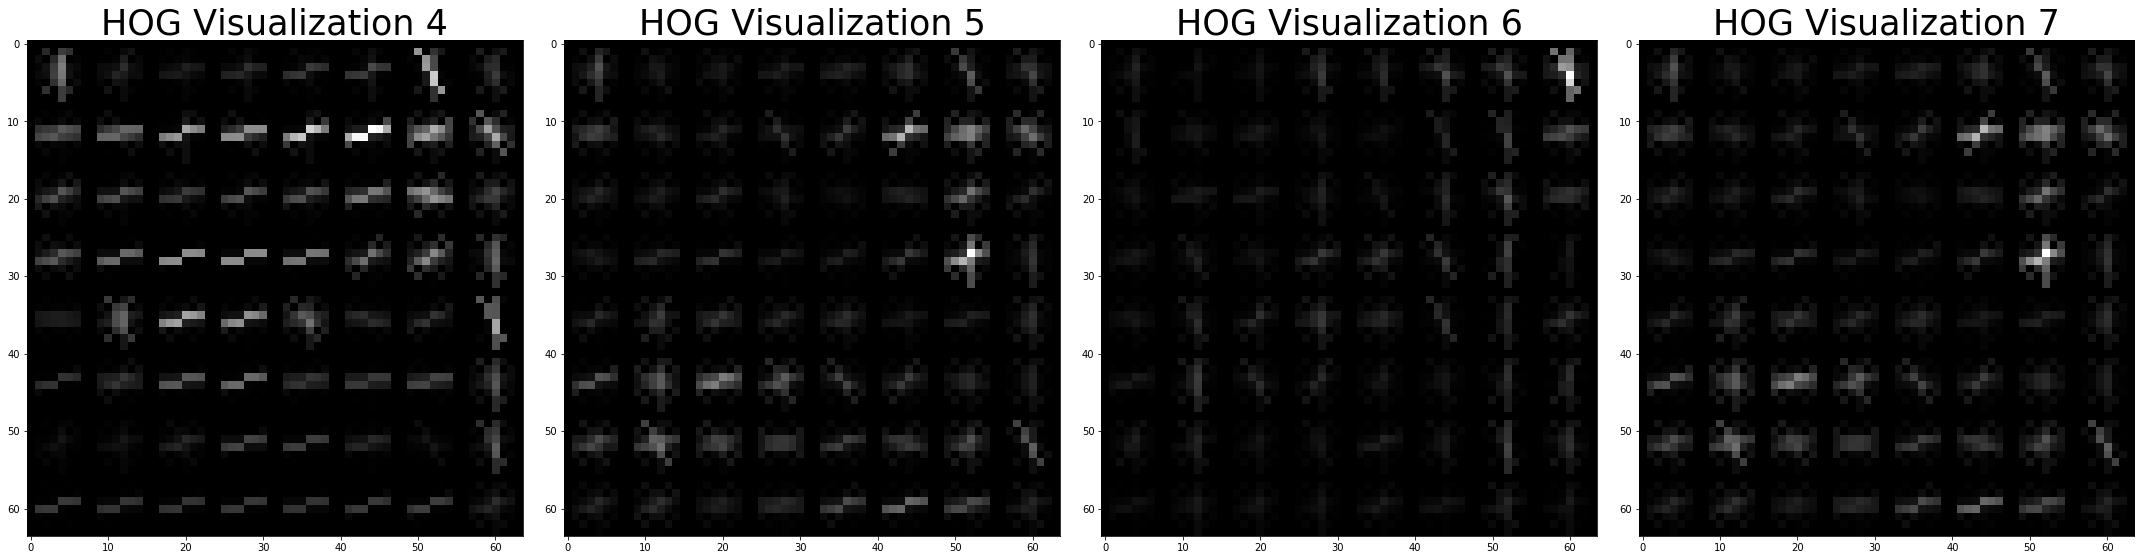

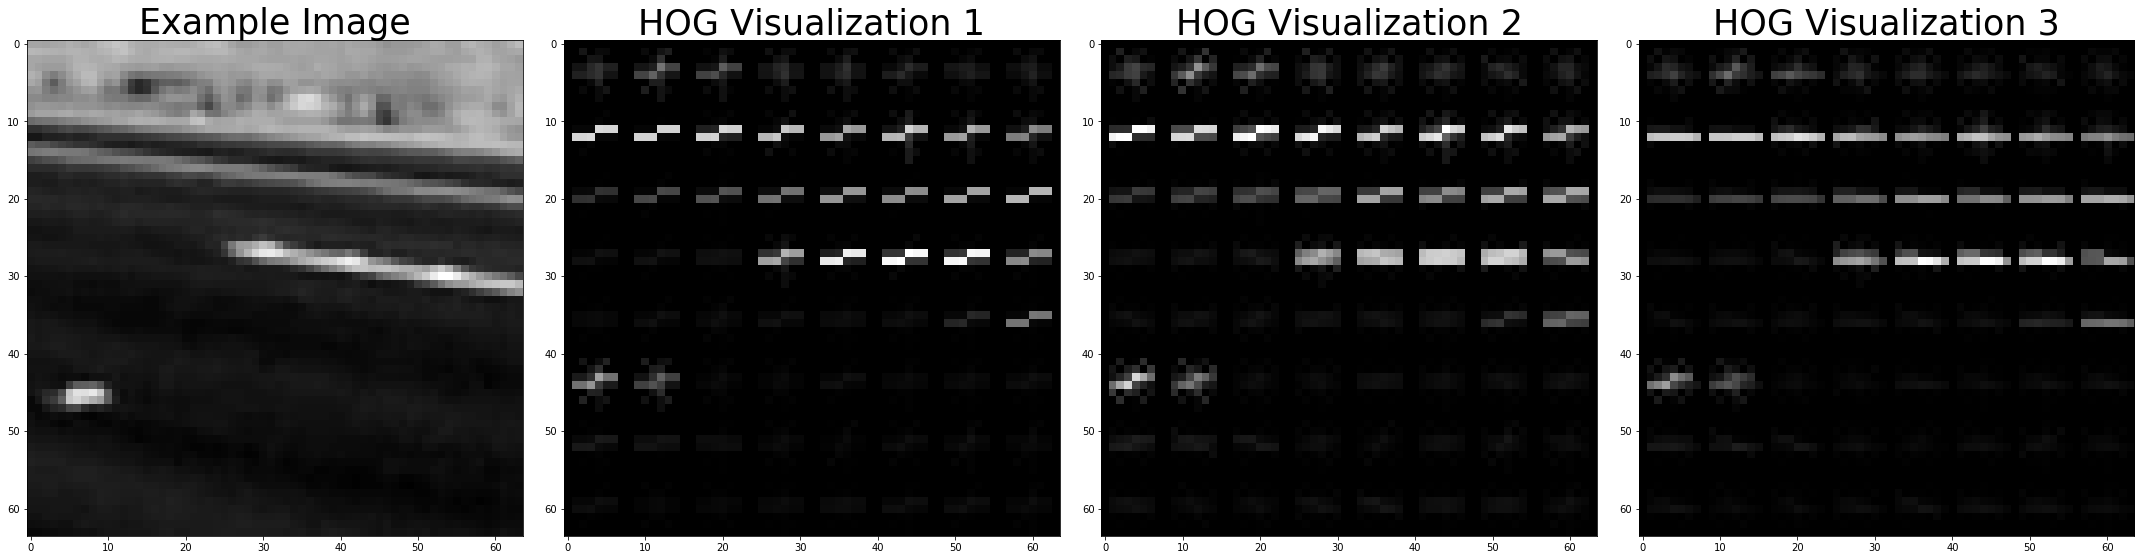

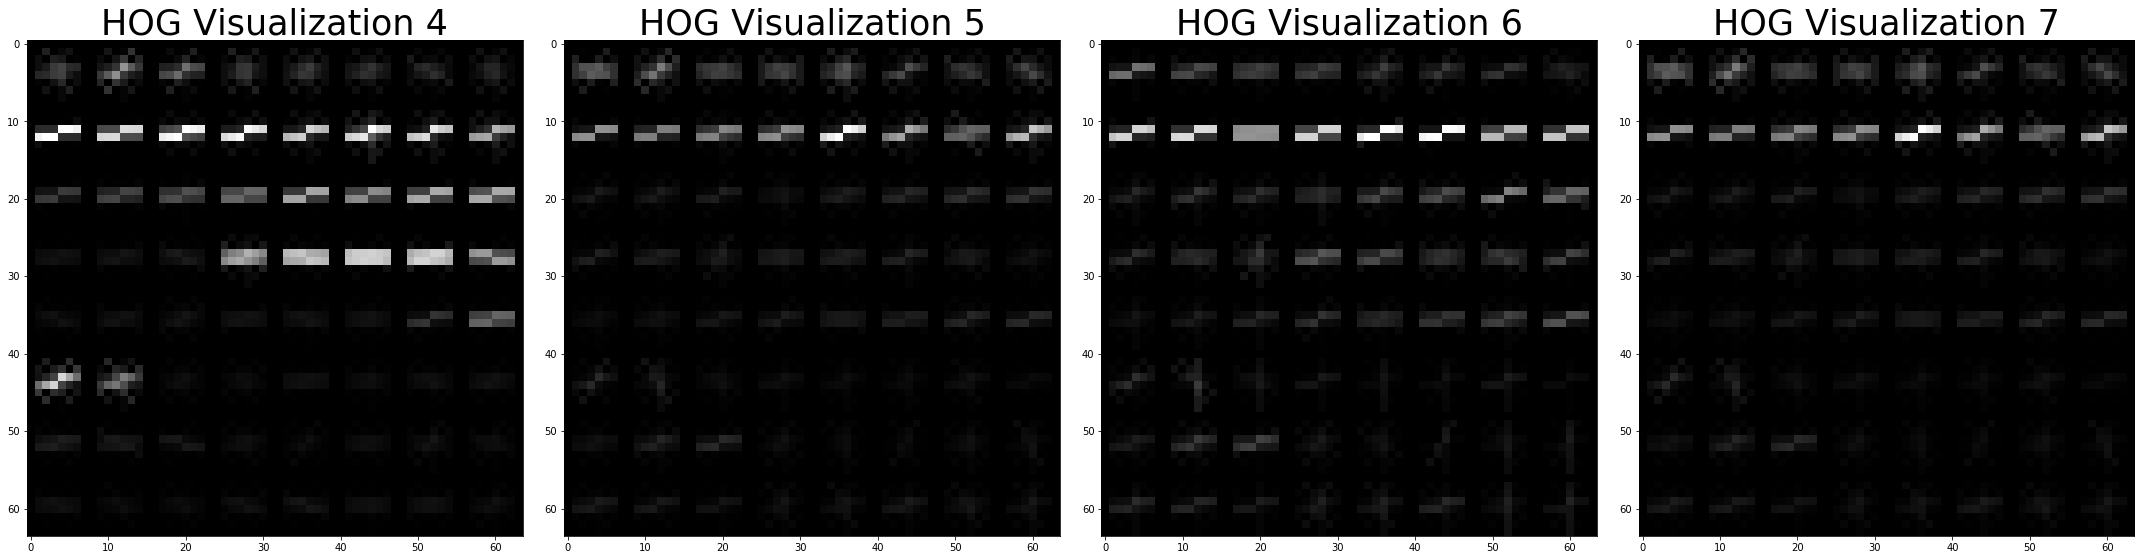

In [16]:
from scipy.ndimage.measurements import label
from queue import Queue

import cv2


img = mpimg.imread('test_images/test1.jpg')
box_queue = Queue(maxsize=3)
heat = np.zeros_like(img[:,:,0]).astype(np.float)

svc, X_scaler = main_function()



def process_image(frame):
    
    global heat 
    global box_queue
    global count
    global img_save

    #if count < 3:
        #frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        #cv2.imwrite('testing/test'+str(count)+'.jpg',frame)
    #count =count +1
#     ystart = [400,400,400,464]
#     ystop = [496,560,592,656]


#     ystart = [400,400,400,440, 464,464]
#     ystop = [528,656,656,636, 656, 656]
#     scale = [1,2,1.5,2, 2.5, 2,2.75] 

    ystart = [400,400,400,400, 464,464]
    ystop = [500,656,528,636, 656, 656]
    scale = [1,2,1.5,2, 1.5, 2,2.75] #4 #1.5 
    colors = [(0,0,255), (255,0,0), (0,255,0), (0,125,55)]
    
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 3 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    if box_queue.full():
        heat = remove_heat(heat,box_queue.get())

    bboxes, box_img = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors)
    
    box_queue.put(bboxes)
    

    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)

    heatmap_image = (np.dstack((heatmap, heatmap, heatmap))*255).astype(np.uint8)
    
#     stack1 = np.hstack((heatmap_image, box_img))
#     stack2 = np.hstack((draw_img, draw_img))
    
#     stack3 = np.vstack((stack1, stack2))

    stack3 = np.hstack((box_img, draw_img))
    
    return stack3
    
    
    
    

### Extract the frame from the video and send it for processing. It calls the process image method which takes image as input and then returns processed image as output.

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_videos_output/test_rbf_full_frame_queue3.mp4'


count = 0
img_save = None
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #.subclip(27,32) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/test_rbf_full_frame_queue3.mp4
[MoviePy] Writing video test_videos_output/test_rbf_full_frame_queue3.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [33:49<00:01,  1.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_rbf_full_frame_queue3.mp4 

Wall time: 33min 53s


## Video output
In the video output on the left side is the output of the hog sub-sampling method and on the right side is the final image after using label from `scipy.ndimage.measurements.label()`.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [20]:
from scipy.ndimage.measurements import label
from queue import Queue

import cv2



def process_image1(frame):
    #if count < 3:
        #frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        #cv2.imwrite('testing/test'+str(count)+'.jpg',frame)
    #count =count +1
#     ystart = [400,400,400,464]
#     ystop = [496,560,592,656]


#     ystart = [400,400,400,440, 464,464]
#     ystop = [528,656,656,636, 656, 656]
#     scale = [1,2,1.5,2, 2.5, 2,2.75] 

    heat = np.zeros_like(frame[:,:,0]).astype(np.float)

    ystart = [400,400,400,400, 464,464]
    ystop = [500,656,528,636, 656, 656]
    scale = [1,2,1.5,2, 1.5, 2,2.75] #4 #1.5 
    colors = [(0,0,255), (255,0,0), (0,255,0), (0,125,55)]
    
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 3 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off


    bboxes, box_img = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colors)
    

    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)

    heatmap_image = (np.dstack((heatmap, heatmap, heatmap))*255).astype(np.uint8)
    
    stack1 = np.hstack((heatmap_image, box_img))
    stack2 = np.hstack((frame, draw_img))
    
    stack3 = np.vstack((stack1, stack2))
    
    return stack3
    
    
    
    

## Image testing pipeline - for testing and image purpose only

The image output is divided into 4 parts. Top_Left, Top_Right, Bottom_Left, Bottom_Right

Top_Left is heatmap of the image
Top_right is image with cars detected
Bottom_Left is original image
Bottom_Right is image after thresholding and labeling

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]D:\carND\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.78s/it]


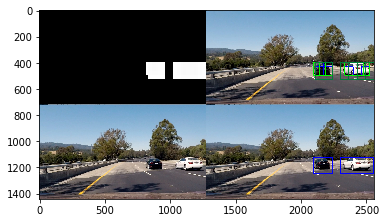

In [21]:
# svc, X_scaler = main_function()

#img = mpimg.imread('test_images/test1.jpg')


ystart = [400,400,400,464]
ystop = [560,656,592,656]
#ystart = 400
#ystop = 656
scale = [1,2,3,4] #4 #1.5
colors = [(0,0,255), (255,0,0), (0,255,0), (0,125,55)]


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


images = glob.glob('test_images/test*.jpg')

for image in tqdm(images) :
    img = mpimg.imread(image)
    stack3 = process_image1(img)
    plt.figure()
    plt.imshow(stack3)